In [ ]:
# !sudo apt-get update -y
# !sudo apt-get install python3.8
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 1
# !sudo apt-get install python3-pip


In [ ]:
!python --version


Python 3.10.12


In [ ]:
# !pip uninstall torch torchvision -y


In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 7.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
torch:  2.4 ; cuda:  cu121
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-l5saup27
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-l5saup27
  Resolved https://github.com/facebookresearch/detectron2.git to commit ebe8b45437f86395352ab13402ba45b75b4d1ddb
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
# import torch, detectron2
# !nvcc --version
# TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
# CUDA_VERSION = torch.__version__.split("+")[-1]
# print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.4 ; cuda:  cu121
detectron2: 0.6


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="MY_API_KEY")
project = rf.workspace("eyezsmartdet").project("alltheimaegs")
version = project.version(2)
dataset = version.download("coco")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.8
    Uninstalling idna-3.8:
      Successfully uninstalled idna-3.8
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to allTheImaegs-2 in coco:: 100%|██████████| 3228/3228 [00:01<00:00, 1718.02it/s]


In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/allTheImaegs-2/train/_annotations.coco.json", "/content/allTheImaegs-2/train")
register_coco_instances("my_dataset_test", {}, "/content/allTheImaegs-2/valid/_annotations.coco.json", "/content/allTheImaegs-2/valid")
register_coco_instances("my_dataset_vv", {}, "/content/allTheImaegs-2/test/_annotations.coco.json", "/content/allTheImaegs-2/test")


WARNING [09/15 02:16:14 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/15 02:16:14 d2.data.datasets.coco]: Loaded 2922 images in COCO format from /content/allTheImaegs-2/train/_annotations.coco.json


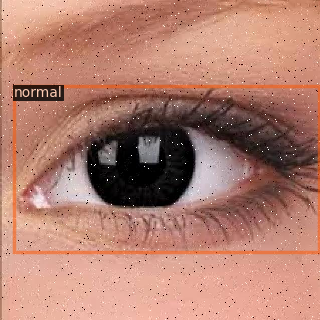

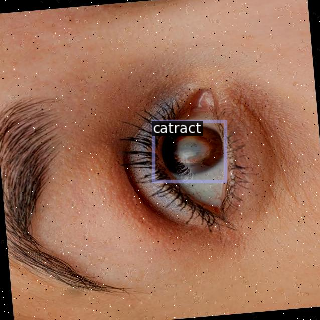

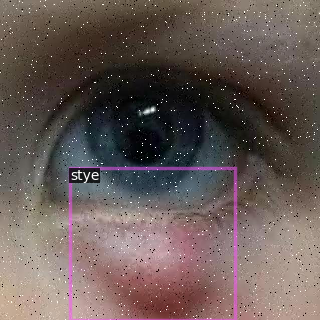

In [ ]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

In [ ]:
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_test",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

In [ ]:


cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 500   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[09/15 02:23:35 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
model_final_280758.pkl: 167MB [00:00, 174MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[09/15 02:23:36 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)


[09/15 02:23:53 d2.utils.events]:  eta: 0:04:50  iter: 19  total_loss: 1.874  loss_cls: 1.485  loss_box_reg: 0.3506  loss_rpn_cls: 0.02321  loss_rpn_loc: 0.008088    time: 0.5927  last_time: 0.6258  data_time: 0.0385  last_data_time: 0.0096   lr: 9.7405e-05  max_mem: 3062M
[09/15 02:24:08 d2.utils.events]:  eta: 0:04:33  iter: 39  total_loss: 0.8597  loss_cls: 0.4585  loss_box_reg: 0.3772  loss_rpn_cls: 0.01811  loss_rpn_loc: 0.0111    time: 0.5932  last_time: 0.5561  data_time: 0.0215  last_data_time: 0.0230   lr: 0.00019731  max_mem: 3062M
[09/15 02:24:20 d2.utils.events]:  eta: 0:04:26  iter: 59  total_loss: 0.7987  loss_cls: 0.3697  loss_box_reg: 0.3976  loss_rpn_cls: 0.007506  loss_rpn_loc: 0.01026    time: 0.6047  last_time: 0.5859  data_time: 0.0282  last_data_time: 0.0236   lr: 0.0002972  max_mem: 3062M
[09/15 02:24:33 d2.utils.events]:  eta: 0:04:18  iter: 79  total_loss: 0.7681  loss_cls: 0.3523  loss_box_reg: 0.3907  loss_rpn_cls: 0.01277  loss_rpn_loc: 0.008582    time: 0.6

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[09/15 02:29:18 d2.evaluation.evaluator]: Inference done 11/163. Dataloading: 0.0012 s/iter. Inference: 0.0811 s/iter. Eval: 0.0003 s/iter. Total: 0.0826 s/iter. ETA=0:00:12
[09/15 02:29:23 d2.evaluation.evaluator]: Inference done 70/163. Dataloading: 0.0018 s/iter. Inference: 0.0824 s/iter. Eval: 0.0003 s/iter. Total: 0.0846 s/iter. ETA=0:00:07
[09/15 02:29:28 d2.evaluation.evaluator]: Inference done 127/163. Dataloading: 0.0027 s/iter. Inference: 0.0831 s/iter. Eval: 0.0003 s/iter. Total: 0.0862 s/iter. ETA=0:00:03
[09/15 02:29:31 d2.evaluation.evaluator]: Total inference time: 0:00:13.911980 (0.088051 s / iter per device, on 1 devices)
[09/15 02:29:31 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:13 (0.083646 s / iter per device, on 1 devices)
[09/15 02:29:31 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/15 02:29:31 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[09/15 02:29:31 d2.evaluation.coc

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_vv", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_vv")
inference_on_dataset(trainer.model, val_loader, evaluator)

[09/15 02:37:06 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


WARNING [09/15 02:37:06 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [09/15 02:37:06 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/15 02:37:06 d2.data.datasets.coco]: Loaded 135 images in COCO format from /content/allTheImaegs-2/test/_annotations.coco.json
[09/15 02:37:06 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |   category    | #instances   |
|:----------:|:-------------|:----------:|:-------------|:-------------:|:-------------|
|   eyess    | 0            |  catract   | 14           | conjunctivi.. | 35           |
|   normal   | 33           | pterygium  | 22           |     stye      | 33           |
|            |              |            |              |               |              |
|   total    | 137          |      

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[09/15 02:37:08 d2.evaluation.evaluator]: Inference done 11/135. Dataloading: 0.0011 s/iter. Inference: 0.0839 s/iter. Eval: 0.0003 s/iter. Total: 0.0853 s/iter. ETA=0:00:10
[09/15 02:37:13 d2.evaluation.evaluator]: Inference done 68/135. Dataloading: 0.0023 s/iter. Inference: 0.0855 s/iter. Eval: 0.0003 s/iter. Total: 0.0882 s/iter. ETA=0:00:05
[09/15 02:37:18 d2.evaluation.evaluator]: Inference done 121/135. Dataloading: 0.0043 s/iter. Inference: 0.0866 s/iter. Eval: 0.0003 s/iter. Total: 0.0914 s/iter. ETA=0:00:01
[09/15 02:37:19 d2.evaluation.evaluator]: Total inference time: 0:00:11.995142 (0.092270 s / iter per device, on 1 devices)
[09/15 02:37:19 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:11 (0.086868 s / iter per device, on 1 devices)
[09/15 02:37:19 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/15 02:37:19 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[09/15 02:37:19 d2.evaluation.coco

OrderedDict([('bbox',
              {'AP': 25.951782001498458,
               'AP50': 57.8172257667886,
               'AP75': 20.84143479329391,
               'APs': nan,
               'APm': 5.971663833049972,
               'APl': 26.812301497110152,
               'AP-eyess': nan,
               'AP-catract': 34.52711804588769,
               'AP-conjunctivitis': 17.25755597131442,
               'AP-normal': 30.830866619159497,
               'AP-pterygium': 47.143369371130696,
               'AP-stye': 0.0})])

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_vv", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_vv")

from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/allTheImaegs-2/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata,
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])